# Unsupervised Machine Learning Techniques II

## Isolation Forest 

Anderson Nelson  <br>
Date: 11/2/2019 <br>

### Introduction: 

This week I'm going to experiment using an Isolation Forest to identify outliers in the healthcare dataset. Last week I evaluated the performances of two different feature selection methods: PCA and correlation threshold. I discovered that nine variables explained 96% of the variation in the healthcare data, and established a correlation threshold of 0.5 to remove the variables. The correlation and PCA both identified the same values as outliers. However, the PCA determined a few additional medicare providers. Given that the problem is an unsupervised method, it's unclear which method performed the best. For this analysis, I'm going to use the dataset with less than 0.5 correlation for simplicity and interpretability. 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns

from pyod.models.iforest import IForest
from pyod.utils.utility import standardizer
from pyod.models.combination import aom, moa, average, maximization

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [2]:
# function used throughout the model 
def correlation_threshold(dataset, threshold):
    """
    Remove columns that do exceeed correlation threshold
    """
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset
    return dataset

In [3]:
# Read data 
data = pd.read_csv('Data/data.csv')
data = data.drop(columns = ['Unnamed: 0','Provider City','K Means 1'])

In [4]:
# filter data for columns with numerical values 
data_subset = data.iloc[:,7:]
data_subset_name = data_subset.columns

# normalized data to reduced the impact of variables on scale 
data_subset_scaled = StandardScaler().fit_transform(data_subset)
data_subset_scaled = pd.DataFrame(data_subset_scaled, columns=data_subset_name)

# any two columns with  correlation of more than 0.5 is removed from the data set, rational is to capture  that add additional value in the data 
model_data = correlation_threshold(data_subset_scaled, 0.5)
print(f' There are {len(model_data.columns)} columns remaining in the data')

 There are 11 columns remaining in the data


In [5]:
# split data based on the first 70% of rows in the data 
train_split_dim = data_subset.shape[0] * 0.7
train_data = data_subset_scaled.loc[1:train_split_dim]
test_data = data_subset_scaled.loc[train_split_dim:]

# filter the main dataset and only includes that passets the correlation test 
X_test_cluster = data_subset.loc[train_split_dim:].copy()
X_test_cluster = X_test_cluster.loc[:, model_data.columns] # dataset used throuhght the document. 

### Isolation Forest Overview 

Isolation  Forest was introduced in 2008 by Fei Tony Liu.  Isolation Forest is an ensemble technique, and it uses the concept of isolation to "explain/separate-away" anomalies. Isolation Forest isn't based on a distance measure, instead, builds an ensemble of random trees,  and the anomalies are determined by the points with the shortest average path length.

Isolation is useful for both supervised and unsupervised problems. 
Isolation forest splits on the best split among randomly chosen variables with randomly chosen split points, this helps to overcome overfitting. It's also possible to implement a bootstrap method as well. 

Isolation forest calculates an anomaly score and seperates into binary based on an anomaly threshhold. The way that the algorithm constructs the separation is by first creating isolation trees or random decision trees. Then, the score is calculated as the path length to isolate the observation. 

Advanced outlier detection methods such as Isolation Forests are effective at reducing fraud because this method detects anomalies based on the concept of isolation without employing any distance or density measure —fundamentally different from all existing methods, which is one of the reasons that I wanted to try using it on this data set. 


I experimented with a few parameters, and I'm using my best judgment based on the results to determine the final parameters, and I'm going to compare three models:

Model 1: {Samples: Auto} <br>
Model 2: {Samples: 100} <br>
Model 3: {Samples: 50} <br>

After expirementing over time, i decided to use my best judgement in determining the thresshold level to seperate the outliers from normal. 

### Model 1 


The model identified 432 outliers and the isolation forest model based the outliers on two categories. Out of Pocket payment, and Average coverage charges, which are 3.2x and 6.3x higher for normal vs outliers.

The model also indicates that out of pocket payment ratio is 3x higher for outliers, which suprised me. I would have though that it would have been lower given. 

### Summary of findings: 
- Payment covered percentage, and coverage ratio is identical for both normal and outlier dataset 
- Low coverage ratio seem to indicate outliers, albeit not strongly defined 


In [6]:
clf1 = IForest(behaviour="new", bootstrap=True,n_jobs=-1,) 
clf1.fit(train_data)

IForest(behaviour='new', bootstrap=True, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=-1, random_state=None,
    verbose=0)

In [7]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores_1 = clf1.decision_function(test_data)  # outlier scores
y_test_scores_1 = pd.Series(y_test_scores_1)

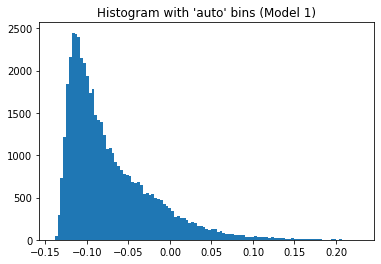

In [8]:
plt.hist(y_test_scores_1,bins = 'auto')
plt.title("Histogram with 'auto' bins (Model 1)")
plt.show()

In [9]:
X_test_cluster['iso1 labels'] = np.where(y_test_scores_1 <0.10, 'Normal', 'Outlier')
X_test_cluster['iso1 labels'].value_counts()

Normal     48448
Outlier      471
Name: iso1 labels, dtype: int64

In [10]:
X_test_cluster.groupby('iso1 labels').mean()

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio
iso1 labels,,,,,,,,,,,
Normal,33409.331418,1072.851858,3.625029,0.347608,0.851888,42.960034,13.006605,46.050855,1.000318,0.997168,0.980491
Outlier,109618.643227,6773.011380,3.735782,0.393300,0.724174,67.600047,18.186837,157.814059,0.964897,1.292448,3.009984


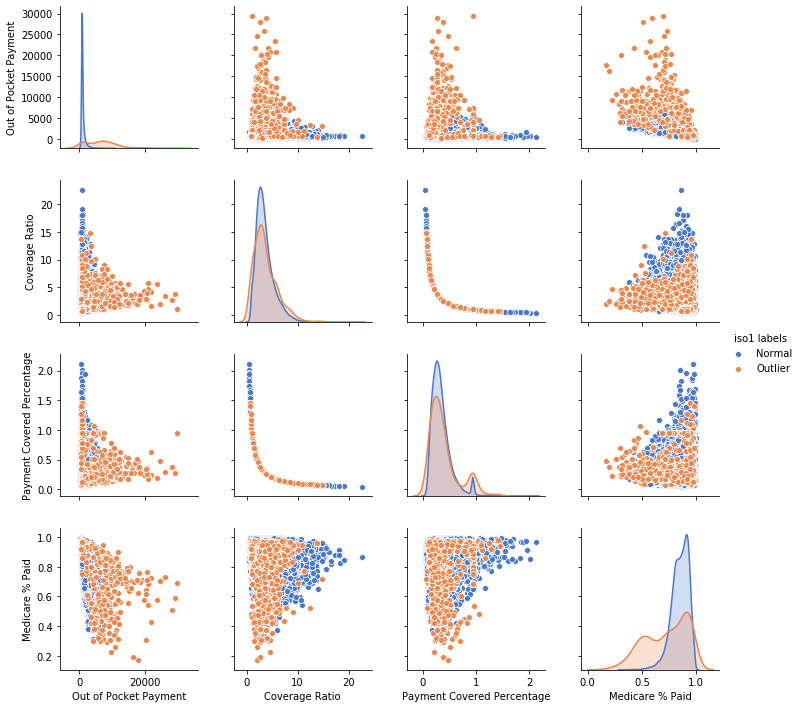

In [11]:
sns.pairplot(X_test_cluster.iloc[:,[1,2,3,4,11]], hue = 'iso1 labels', palette='muted')

### Model 2 
findings are consitent with model 1. There are no significant difference


In [12]:
clf2 = IForest(max_samples=100, bootstrap=True,n_jobs=-1,) 
clf2.fit(train_data)

IForest(behaviour='old', bootstrap=True, contamination=0.1, max_features=1.0,
    max_samples=100, n_estimators=100, n_jobs=-1, random_state=None,
    verbose=0)

In [13]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores_2 = clf2.decision_function(test_data)  # outlier scores
y_test_scores_2 = pd.Series(y_test_scores_2)
y_test_scores_2.head()

0   -0.041630
1   -0.038784
2    0.015646
3   -0.067131
4   -0.028644
dtype: float64

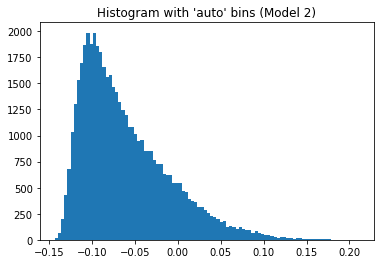

In [14]:
plt.hist(y_test_scores_2,bins = 'auto')
plt.title("Histogram with 'auto' bins (Model 2)")
plt.show()

In [15]:
X_test_cluster['iso2 labels'] = np.where(y_test_scores_2 <0.10, 'Normal', 'Outlier')
X_test_cluster['iso2 labels'].value_counts()

Normal     48525
Outlier      394
Name: iso2 labels, dtype: int64

In [16]:
X_test_cluster.groupby('iso2 labels').mean()

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio
iso2 labels,,,,,,,,,,,
Normal,33358.945475,1081.998906,3.622827,0.347725,0.851651,43.085559,13.007501,46.337535,1.000876,0.997181,0.983073
Outlier,130717.868858,6760.452437,4.028596,0.387883,0.728361,56.955828,19.088832,144.348618,0.889249,1.348603,3.088612


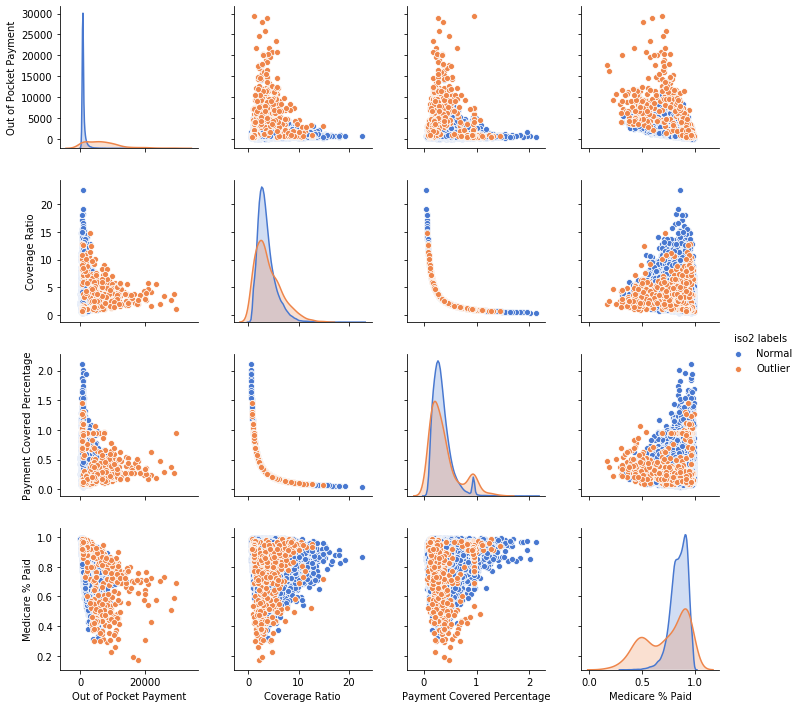

In [17]:
sns.pairplot(X_test_cluster.iloc[:,[1,2,3,4,12]], hue = 'iso2 labels',palette='muted')

### Model 3 

Findings are also consistent with model 1 and 2 

In [18]:
clf3 = IForest(behaviour="new", max_samples=50, bootstrap=True,n_jobs=-1,) 
clf3.fit(train_data)

IForest(behaviour='new', bootstrap=True, contamination=0.1, max_features=1.0,
    max_samples=50, n_estimators=100, n_jobs=-1, random_state=None,
    verbose=0)

In [19]:
# clf.decision_function: Predict raw anomaly score of X using the fitted detector.
# We apply the model to the test data X_test to get the outlier scores.
y_test_scores_3 = clf3.decision_function(test_data)  # outlier scores
y_test_scores_3 = pd.Series(y_test_scores_3)
y_test_scores_3.head()

0   -0.049759
1   -0.028610
2    0.018271
3   -0.099664
4   -0.043042
dtype: float64

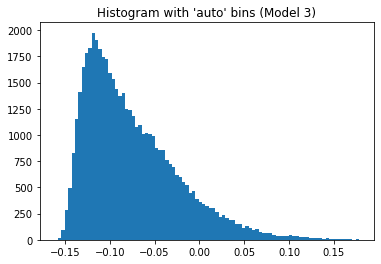

In [20]:
plt.hist(y_test_scores_3,bins = 'auto')
plt.title("Histogram with 'auto' bins (Model 3)")
plt.show()

In [21]:
X_test_cluster['iso3 labels'] = np.where(y_test_scores_3 <0.10, 'Normal', 'Outlier')
X_test_cluster['iso3 labels'].value_counts()

Normal     48595
Outlier      324
Name: iso3 labels, dtype: int64

In [38]:
X_test_cluster.groupby('iso3 labels').mean()

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio
iso3 labels,,,,,,,,,,,
Normal,33307.252345,1081.818996,3.620052,0.348317,0.851397,43.199486,13.043914,46.284489,1.000262,0.997534,0.987061
Outlier,159505.375895,8014.262562,4.532546,0.307681,0.739774,42.865073,14.941358,173.479896,0.957182,1.371582,2.945292


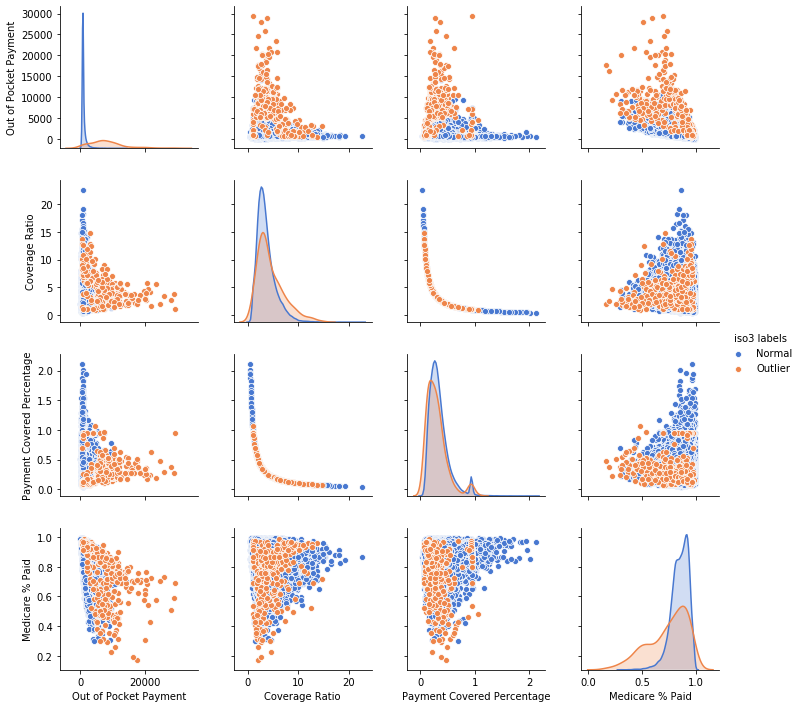

In [24]:
sns.pairplot(X_test_cluster.iloc[:,[1,2,3,4,13]], hue = 'iso3 labels',palette='muted')

### Evaluate models 

Utilizing only 1 model for your prediction can be dangerous, especially since it there's a lot of subjectivity in how the paramaters were determined. In this section I will combine the models using the average and maxium of maximum technique

In [25]:
# The predictions of the training data can be obtained by clf.decision_scores_.
# It is already generated during the model building process.
train_scores = pd.DataFrame({'clf1': clf1.decision_scores_,
                             'clf2': clf2.decision_scores_,
                             'clf3': clf3.decision_scores_
                            })

# The predictions of the test data need to be predicted using clf.decision_function(X_test)
test_scores  = pd.DataFrame({'clf1': clf1.decision_function(test_data),
                             'clf2': clf2.decision_function(test_data),
                             'clf3': clf3.decision_function(test_data) 
                            })

In [26]:
# Although we did standardization before, it was for the variables.
# Now we do the standardization for the decision scores
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

### Average

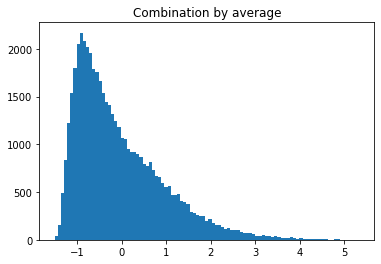

In [27]:
# Combination by average
y_by_average = average(test_scores_norm)
             
plt.hist(y_by_average, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [28]:
df_test_avg = pd.DataFrame(test_data)
X_test_cluster['y_by_average_cluster'] = np.where(y_by_average<3, 'Normal', 'Outlier')
X_test_cluster['y_by_average_cluster'].value_counts()

Normal     48395
Outlier      524
Name: y_by_average_cluster, dtype: int64

In [29]:
X_test_cluster.groupby('y_by_average_cluster').mean()

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio
y_by_average_cluster,,,,,,,,,,,
Normal,33098.004068,1068.332888,3.620602,0.347890,0.851883,43.085921,13.008493,45.949676,1.000717,0.996623,0.980112
Outlier,130663.669122,6613.826450,4.133442,0.362643,0.737500,53.481302,17.488550,155.854313,0.931631,1.312918,2.839633


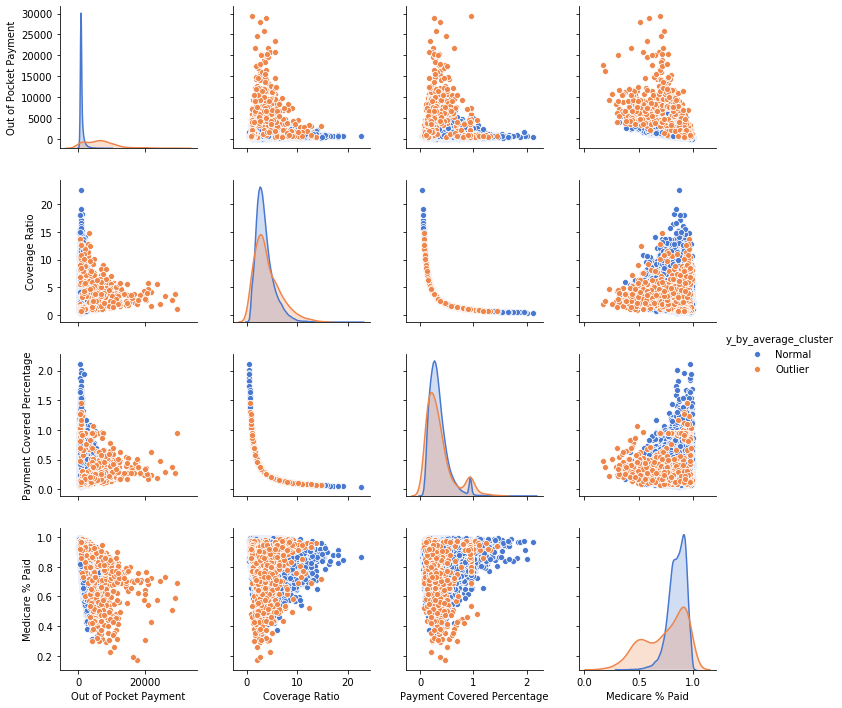

In [30]:
sns.pairplot(X_test_cluster.iloc[:,[1,2,3,4,14]], hue = 'y_by_average_cluster', palette='muted')

### Maximum of maximum

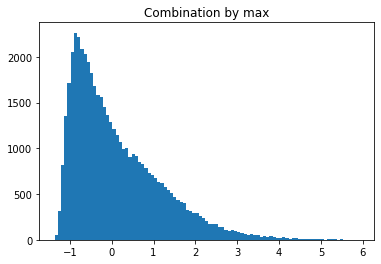

In [31]:
# Combination by max
y_by_maximization = maximization(test_scores_norm)
             
plt.hist(y_by_maximization, bins='auto')  # arguments are passed to np.histogram
plt.title("Combination by max")
plt.show()

In [32]:
df_test_max = pd.DataFrame(test_data)
X_test_cluster['y_by_maximization_cluster'] = np.where(y_by_maximization<4, 'Normal', 'Outlier')
X_test_cluster['y_by_maximization_cluster'].value_counts()

Normal     48703
Outlier      216
Name: y_by_maximization_cluster, dtype: int64

In [33]:
X_test_cluster.groupby('y_by_maximization_cluster').mean()

,Average Covered Charges,Out of Pocket Payment,Coverage Ratio,Payment Covered Percentage,Medicare % Paid,mean_discharge_per_drg_state_region,mean_trans_per_drg_state_region,mean_oop_per_discharge_drg_state_region,total_discharge_ratio,ratio_average_total_payment,ratio_oop_payment_ratio
y_by_maximization_cluster,,,,,,,,,,,
Normal,33708.173015,1092.043074,3.625338,0.347892,0.851428,43.135765,13.039915,46.520450,1.000472,0.998121,0.988024
Outlier,132206.107315,9175.191481,3.796780,0.383214,0.676949,57.065489,16.791667,183.873881,0.888462,1.426168,3.707219


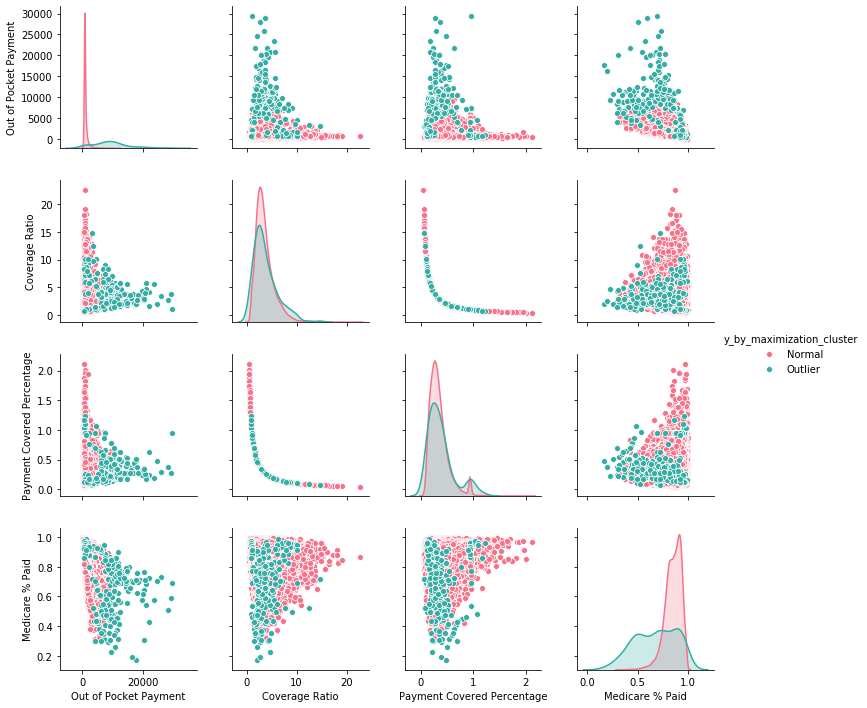

In [34]:
sns.pairplot(X_test_cluster.iloc[:,[1,2,3,4,15]], hue = 'y_by_maximization_cluster', palette= 'husl')

#### Was there any difference in the medical providers identified by the difference approaches?

I wanted to evaluated the difference in prediction between the different techniques, and it seems that on average they consistently label the label categories the same ~99% of the time. Which isn't suprising. However, the outliers are consistent ~20% of the time

In [35]:
normal_pct_all = []
outlier_pct_all = []

for value in range(0,len(X_test_cluster)): 
    
    subset = X_test_cluster.iloc[value,11:17]
    normal_pct = np.count_nonzero(X_test_cluster.iloc[value,11:17] == 'Normal')
    outlier_pct = np.count_nonzero(X_test_cluster.iloc[value,11:17] == 'Outlier')
    
    if normal_pct == 0: 
        continue
    else: 
        normal_pct_all.append(normal_pct)
        
    if outlier_pct == 0: 
        continue
    else: 
        outlier_pct_all.append(outlier_pct)

In [39]:
np.mean(normal_pct_all)

4.978581100488285

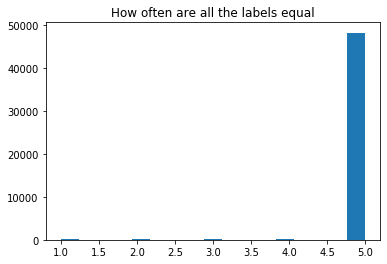

In [37]:
plt.hist(normal_pct_all, bins='auto')
plt.title('How often are all the labels equal')
plt.show()

In [41]:
np.mean(outlier_pct_all)

2.389016018306636

Only ~ 200 medicare providers are consistently identified as fraud. Defined as the providers that appear in 3 or more of the techniques. 

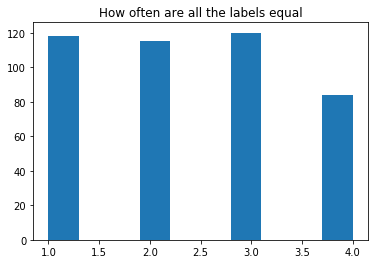

In [36]:
plt.hist(outlier_pct_all)
plt.title('How often are all the labels equal')
plt.show()

In [ ]:
np.mean(outlier_pct_all)

### Conclusion: 

After trying all these different techniques, I'm a little skeptical of single isolation forest ability to identify fraud in this dataset. By combing the different approaches, I believe it creates a higher level of confidence, especially since each parameter selection contains bias. My recommendation would be investigating the accounts that are anomalies in 3 or more of the uniques techniques utilized. The key takeaway is that combining results from results from different models increases prediction confidence, and reduce bias. 
   

### References: 
    
[Anomaly Detection with Isolation Forest & Visualization](https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2) <br>
[Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf) <br>
[Isolation-based Anomaly Detection](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf) <br>
[ Benefits of Anomaly Detection Using Isolation Forests ](https://blog.easysol.net/using-isolation-forests-anamoly-detection/)
